In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import time

import seaborn as sns
from scipy import ndimage

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('running on:', device)

running on: cuda:0


In [3]:
SOURCE_IMG_SIZE = 48
IMG_SIZE = 96

CLASSES = ['neutral', 'happy', 'surprised', 'sad', 'angry'] #, 'disgusted', 'afraid'
NUM_CLASSES = len(CLASSES)

## Pre-processing

In [4]:
df_fer = pd.read_csv('../data/fer2013.csv').iloc[:, 1:]
df_ferplus = pd.read_csv('../data/ferplus2013.csv').iloc[:, [2, 3, 4, 5, 6]] # Change this if size of classes is changed
df = df_fer.join(df_ferplus)
# df.head(15)

df['emotion'] = df.iloc[:, 2:].idxmax(axis=1).tolist()
df = df.replace(dict(zip(pd.Series(CLASSES),pd.Series(CLASSES).index)))
# df.head(15)

print('number of images:', df.shape[0])
df = df[(df.iloc[:, 2:-1].max(axis=1) > 5)]
print('after removing images with unknown/unsure classification:', df.shape[0])
# df.head(15)

df = df.iloc[:, [0, 1, -1]]
# df.head(15)

number of images: 35887
after removing images with unknown/unsure classification: 26811


In [5]:
# ---- Normal Dataset ----
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

images_np = np.array(df['pixels'])
label_np = np.array(df['emotion'])

images = []
images_raw = []
labels = []

for i in range(df.shape[0]):
    b = bytes(int(p) for p in images_np[i].split())
    img = Image.frombuffer('L', (SOURCE_IMG_SIZE, SOURCE_IMG_SIZE), b)
    images.append(transform(img))
    images_raw.append(img)
    labels.append(label_np[i])

# ---- Large Dataset ----
# transform = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.RandomRotation(30),
# ])

# images_np = np.array(df['pixels'])
# label_np = np.array(df['emotion'])

# images = []
# images_raw = []
# labels = []

# for i in range(df.shape[0]):
#     for j in range(4):
#         b = bytes(int(p) for p in images_np[i].split())
#         img = Image.frombuffer('L', (SOURCE_IMG_SIZE, SOURCE_IMG_SIZE), b)
#         transformed_img = transform(img)
#         transformed_img[transformed_img == 0] = 0.5
#         images.append(transformed_img)

#         images_raw.append(img)
#         labels.append(label_np[i])

## Filtering

In [6]:
kirsch_compass_masks = [
    np.array([[-3,-3,5],[-3,0,5],[-3,-3,5]]),   # north
    np.array([[-3,-3,-3],[-3,0,5],[-3,5,5]]),   # north-east
    np.array([[-3,-3,-3],[-3,0,-3],[5,5,5]]),   # east
    np.array([[-3,-3,-3],[5,0,-3],[5,5,-3]]),   # south-east
    # np.array([[5,-3,-3],[5,0,-3],[5,-3,-3]]),   # south
    # np.array([[5,5,-3],[5,0,-3],[-3,-3,-3]]),   # south-west 
    # np.array([[5,5,5],[-3,0,-3],[-3,-3,-3]]),   # west
    # np.array([[-3,5,5],[-3,0,5],[-3,-3,-3]]),   # north-west
]

In [7]:
images_filtered = []

transform = transforms.Compose([
    transforms.ToTensor()
])

for i in range(len(images)):
    img = images[i].squeeze(0)

    filtered = np.zeros_like(img)
    for cm in kirsch_compass_masks:
        k = ndimage.convolve(img, cm, mode='nearest', cval=0.0)
        filtered = np.add(filtered, k)

    filtered = transform(filtered)
    images_filtered.append(filtered)

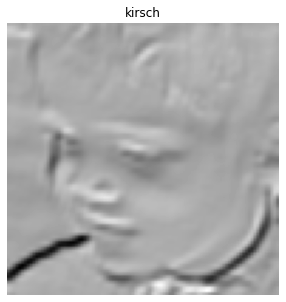

In [8]:
img = images_filtered[random.randint(0, len(images_filtered)-1)]

plt.figure(figsize=(5,5))
plt.title('kirsch')
plt.axis('off')
plt.imshow(img.permute(1,2,0), cmap='gray')

In [9]:
label_counts = [0]*NUM_CLASSES

for i in range(len(labels)):
    label_counts[labels[i]] += 1

print('\033[4m{: <15} {: >10}\033[0m'.format('class', '#images'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >10}'.format(CLASSES[i], label_counts[i]))

class              #images
neutral               9494
happy                 8802
surprised             3461
sad                   2958
angry                 2096


In [10]:
train_split_pct = 0.8
train_len = int(len(labels) * train_split_pct)

train_images = images_filtered[:train_len]
train_labels = labels[:train_len]
test_images = images_filtered[train_len:]
test_labels = labels[train_len:]

print(f'train length: {len(train_labels)} ({len(train_labels)*100/len(labels):.1f}%)')
print(f'test length: {len(test_labels)} ({len(test_labels)*100/len(labels):.1f}%)')

train length: 21448 (80.0%)
test length: 5363 (20.0%)


In [11]:
BATCH_SIZE = 32


class CustomDataset(Dataset):
    
    def __init__(self, images, labels):      
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)


def get_loader(dataset):
    print('get_loader():')

    label_counts = [0]*NUM_CLASSES
    for i in range(len(dataset.labels)):
        label_counts[dataset.labels[i]] += 1

    class_weights = pow(np.array(label_counts) / sum(label_counts), -1)
    print('  class weights:', class_weights.round(3), '\n')

    sample_weights = [0]*len(dataset)
    for idx, (image, label) in enumerate(dataset):
        sample_weights[idx] = class_weights[label]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return DataLoader(dataset, BATCH_SIZE, sampler=sampler, shuffle=False)


train_loader = get_loader(train_dataset)
test_loader = get_loader(test_dataset)

get_loader():
  class weights: [ 2.848  3.015  7.771  8.963 12.991] 

get_loader():
  class weights: [ 2.732  3.175  7.65   9.492 12.052] 



-----
# AlexNet Model

In [12]:
# Batch size during training, remember to change the global one as well
batch_size = BATCH_SIZE

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
lr = 0.01

In [13]:
# Function for displaying predictions for a few images, in this case 6.
#print(test_set[0])

class_names = CLASSES
print(class_names)

def visualize_expression_model(model, num_images=4):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plt.imshow(inputs.cpu().data[j].permute(1, 2, 0), cmap="gray")

                if images_so_far == num_images:
                    return

['neutral', 'happy', 'surprised', 'sad', 'angry']


In [14]:
loss_train = []
accuracy_train = []

def train_expression_model(model, data, criterion, optimizer):
    since = time.time()
    best_acc = 0.0
    model.train()   # Set model to train mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients, and use backpropagatation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    loss_train.append(epoch_loss)
    accuracy_train.append(epoch_acc)

    print('train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [15]:
loss_test = []
accuracy_test = []
y_actual = []
y_pred = []

def test_expression_model(model, data, criterion):
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predy = model(inputs)

        y_actual.extend(labels.cpu())
        y_pred.extend(predy.argmax(1).cpu())
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)

    loss_test.append(epoch_loss)
    accuracy_test.append(epoch_acc)

    print('test Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

In [16]:
# This is a recreation of the AlexNet model. https://pytorch.org/vision/0.12/_modules/torchvision/models/alexnet.html

class Facial_Expression_Network_AlexNet(nn.Module):
    def __init__(self):
        super(Facial_Expression_Network_AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, IMG_SIZE, kernel_size=(3,3), stride=(1, 1), padding=(2, 2)), 
            nn.ReLU(inplace=True), # Rectified Linear Unit activation function
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False), # pooling layer for reducing dimensions
            nn.Conv2d(IMG_SIZE, 192, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6)) # Applies a 2D adaptive average pooling over an input composed of several input planes.


        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False), # Dropout layer for setting 50% of the activations to 0, fording the network to not rely on any 1 node
            nn.Linear(in_features=9216, out_features=4096, bias=True), # Linear layer
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=NUM_CLASSES, bias=True),
        ) # ---- Change out_features if change in amount of classes ----


        self.softmax = nn.Softmax(dim=1) # last activation function for the network, normalizing the output
        self.softmax_result = 0 

    def forward(self, x, verbose=False):
        x = self.features(x)
        x = self.avgpool(x)

        # The data needs to be flattened after the AdaptiveAvgPool2d as its output is H x W
        # This is because the classifier's first layer is a Linear layer
        x = torch.flatten(x, 1)

        x = self.classifier(x) 
        self.softmax_result = self.softmax(x)
        return x

In [17]:
expression_model = Facial_Expression_Network_AlexNet().to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(expression_model.parameters(), lr=lr, momentum = 0.8)
#optimizer = torch.optim.Adam(expression_model.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 1 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.0001)

In [18]:
for epoch in range(1, (num_epochs+1)):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print()
    train_expression_model(expression_model, train_loader, loss_fn, optimizer)
    test_expression_model(expression_model, test_loader, loss_fn)
    scheduler.step

# Normal dataset:
#   Train: Loss = 0.0076, Acc = 0.9222
#   Test: Loss = 0.0160, Acc = 0.8408
#   Time = 12 min
#   Epoks = 15

# Large dataset (x4): 
#   Train: Loss = 0.0016, Acc = 0.9821
#   Test: Loss = 0.0218, Acc = 0.8287
#   Time = 100 min
#   Epoks = 35

Epoch 1/15

train Loss: 0.0478 Acc: 0.2961
test Loss: 0.0437 Acc: 0.4037
Epoch 2/15

train Loss: 0.0353 Acc: 0.5514
test Loss: 0.0282 Acc: 0.6537
Epoch 3/15

train Loss: 0.0254 Acc: 0.6826
test Loss: 0.0221 Acc: 0.7197
Epoch 4/15

train Loss: 0.0204 Acc: 0.7512
test Loss: 0.0212 Acc: 0.7481
Epoch 5/15

train Loss: 0.0169 Acc: 0.7956
test Loss: 0.0182 Acc: 0.7858
Epoch 6/15

train Loss: 0.0140 Acc: 0.8318
test Loss: 0.0185 Acc: 0.7856
Epoch 7/15

train Loss: 0.0121 Acc: 0.8555
test Loss: 0.0154 Acc: 0.8148
Epoch 8/15

train Loss: 0.0101 Acc: 0.8826
test Loss: 0.0172 Acc: 0.8126
Epoch 9/15

train Loss: 0.0090 Acc: 0.8954
test Loss: 0.0174 Acc: 0.8079
Epoch 10/15

train Loss: 0.0076 Acc: 0.9113
test Loss: 0.0170 Acc: 0.8309
Epoch 11/15

train Loss: 0.0067 Acc: 0.9222
test Loss: 0.0160 Acc: 0.8408
Epoch 12/15

train Loss: 0.0060 Acc: 0.9285
test Loss: 0.0167 Acc: 0.8329
Epoch 13/15

train Loss: 0.0051 Acc: 0.9387
test Loss: 0.0178 Acc: 0.8408
Epoch 14/15

train Loss: 0.0049 Acc: 0.9450
tes

In [19]:
#torch.save(expression_model.state_dict(), "face_expression_filtered_model.pt")

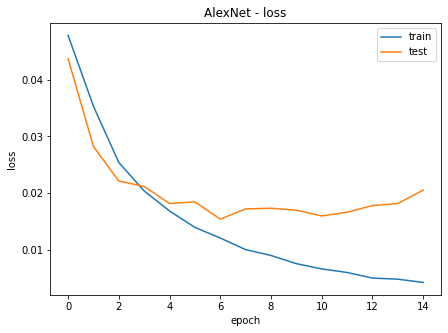

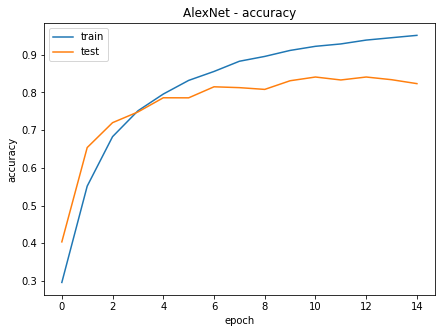

In [20]:
def plot_metric(train, test, metric, title):
    plt.figure(figsize = (7, 5))

    train = torch.tensor(train, device='cpu')
    test = torch.tensor(test, device='cpu')

    with torch.no_grad():
        plt.plot(range(len(train)), train, label = "train")
        plt.plot(range(len(test)), test, label = "test")
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.legend()

    # plt.savefig(f'{title}.png')
    plt.show()


plot_metric(loss_train, loss_test, 'loss', 'AlexNet - loss')
plot_metric(accuracy_train, accuracy_test, 'accuracy', 'AlexNet - accuracy')

Text(87.0, 0.5, 'Actual')

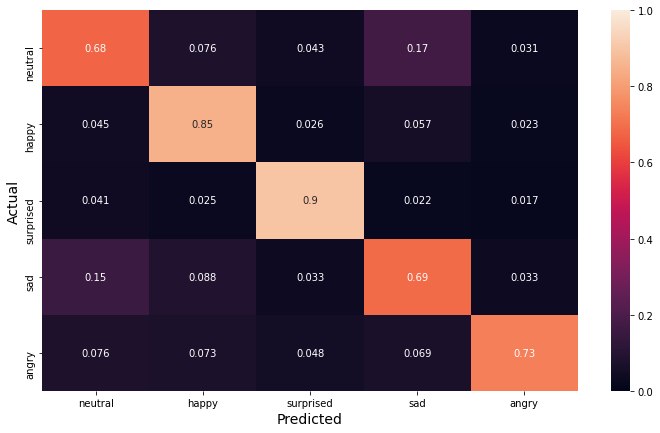

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


counts = np.array([(np.array(y_actual) == i).sum() for i in range(NUM_CLASSES)]).reshape(-1, 1)
cf_matrix = confusion_matrix(y_actual, y_pred)
cf_matrix_norm = cf_matrix / counts

df_cm = pd.DataFrame(cf_matrix_norm, index = CLASSES, columns = CLASSES)
plt.figure(figsize = (12,7))
s = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("rocket", as_cmap=True), vmin=0, vmax=1)
s.set_xlabel('Predicted', fontsize=14)
s.set_ylabel('Actual', fontsize=14)

# plt.savefig('confusion_matrix.png')

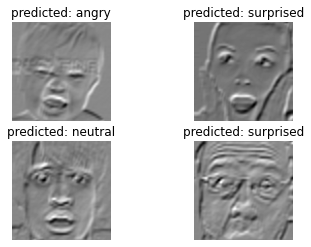

In [22]:
visualize_expression_model(expression_model)

##### End of AlexNet Model
-----

In [23]:
samples_train = [0]*NUM_CLASSES
samples_test = [0]*NUM_CLASSES

for idx, (images_filtered, labels) in enumerate(train_loader):
    for i in range(len(images_filtered)):
        samples_train[labels[i].item()] += 1

for idx, (images_filtered, labels) in enumerate(test_loader):
    for i in range(len(images_filtered)):
        samples_test[labels[i].item()] += 1


print('\033[4m{: <15} {: >15} {: >20}\033[0m'.format('class', '#samples (train)', '#samples (test)'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >15} {: >20}'.format(CLASSES[i], samples_train[i], samples_test[i]))

class           #samples (train)      #samples (test)
neutral                    4363                 1066
happy                      4194                 1079
surprised                  4336                 1059
sad                        4339                 1108
angry                      4216                 1051


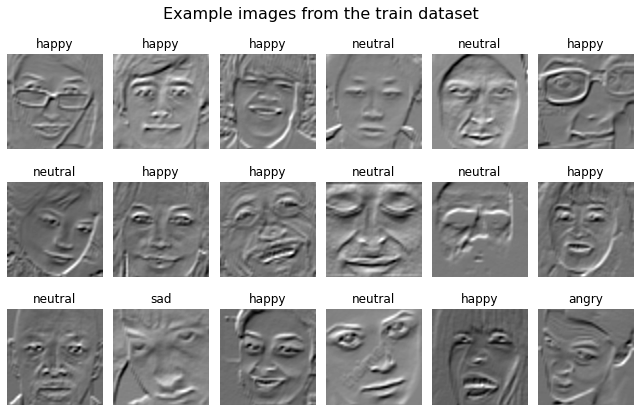

In [24]:
def imshow(dataset, title='', num_images=(3,6), rand=True):

    plt.figure(figsize=(num_images[1]*1.5, num_images[0]*2)); 
    plt.suptitle(title, fontsize=16)

    for i in range(num_images[0]):
        for j in range(num_images[1]):
            
            c = num_images[1]*i+(j+1)

            if not rand:
                idx = c
            else:
                idx = random.randint(0, len(dataset)-1)

            plt.subplot(num_images[0], num_images[1], c); plt.axis('off'); plt.title(CLASSES[dataset[idx][1]])
            plt.imshow(dataset[idx][0].permute(1,2,0), cmap='gray')

    plt.tight_layout(); plt.show()


imshow(train_dataset, 'Example images from the train dataset')